# Objective: Predict Customer Retention of a Travel Company

In [132]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import data science packages
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [133]:
#import data
path = 'STC_csv'

df = pd.read_csv (path, header = 0)
df.head()


,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,...,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
0,1,HS,4.0,4.0,CA,0,1,A,40557,40557,...,K,Elementary,K->Elementary,H,1,0.063646,0.936508,4,L,1
1,2,HC,8.0,8.0,AZ,0,7,A,40557,40564,...,Middle,Middle,Middle->Middle,H,1,0.025882,0.880000,3,L,1
2,3,HD,8.0,8.0,FL,0,3,A,40558,40560,...,Middle,Middle,Middle->Middle,H,1,0.025131,0.888889,3,L,1
3,4,HN,9.0,12.0,VA,1,3,B,40558,40560,...,Undefined,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0
4,5,HD,6.0,8.0,FL,0,6,T,40559,40564,...,Middle,Middle,Middle->Middle,H,0,0.112500,0.910112,8,M-L,0


In [134]:
#df.info()

# Data Cleaning

Step 1 : Change Type;
Step 2: Group categories with low frequency;
Step 3: Impute missing values;
Step 4: Dummy variables;

In [135]:
# Data Cleaning Step 1: Datatype are wrong in some cases, so we need to change it to from float to category

df['From.Grade'] = df['From.Grade'].astype('category')
df['To.Grade'] = df['To.Grade'].astype('category')
df['Is.Non.Annual.'] = df['Is.Non.Annual.'].astype('category')
df['Parent.Meeting.Flag'] = df['Parent.Meeting.Flag'].astype('category')
df['Days'] = df['Days'].astype('category')
df['CRM.Segment'] = df['CRM.Segment'].astype('category')
df['MDR.High.Grade'] = df['MDR.High.Grade'].astype('category')
df['School.Sponsor'] = df['School.Sponsor'].astype('category')
df['NumberOfMeetingswithParents'] = df['CRM.Segment'].astype('category')
df['SingleGradeTripFlag'] = df['SingleGradeTripFlag'].astype('category')

In [136]:
#df.info ()

In [152]:
#Checking categories in each column

#for col in df.select_dtypes(include=['category','object','bool']).columns:
#    print(col)
#    print(df[col].value_counts())
#    print('\n') 

In [138]:
#Data Cleaning Step 2: Grouping categories which are below 10

#Function which will group data, taken from stackoverflow

def CombineRareCategories(data, mincount):
    for col in data.columns:
        if (type(data[col][0]) == str):
            for index, row in pd.DataFrame(data[col].value_counts()).iterrows():
                if ( row[0] < mincount):
                    df[col].replace(index, 'Other_' + col, inplace = True)
                else:
                    None

In [139]:
CombineRareCategories(df, 10)


In [140]:
#check for missing data
#pd.DataFrame(df).isna().sum()

In [141]:
#Data cleaning Step 3: Imputing Missing data

# creating surrogates column indicating missing value
for col in df:
    if df[col].isna().sum() != 0: 
        df[col + '_surrogate'] = df[col].isna().astype(int)

# fixing categoricals with missing value
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
            
# fixing numericals with median
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))


In [142]:
#Data Cleaning Step 4: Creating dummy variables of categories
df = pd.get_dummies(df, columns = df.select_dtypes(exclude=['int64','float64']).columns, drop_first = True)
df.head()  # our dataset now has 252 columns(!)

,ID,Is.Non.Annual.,Days,Departure.Date,Return.Date,Deposit.Date,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,...,GroupGradeType_PK->High,GroupGradeType_PK->Middle,GroupGradeType_Undefined->Undefined,MajorProgramCode_H,MajorProgramCode_I,MajorProgramCode_S,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,SchoolSizeIndicator_missing_value
0,1.0,0.0,1.0,40557.0,40557.0,40420.0,424.0,25.0,3.0,0.424,...,0,0,0,1,0,0,0,0,0,0
1,2.0,0.0,7.0,40557.0,40564.0,40132.0,2350.0,9.0,9.0,0.409,...,0,0,0,1,0,0,0,0,0,0
2,3.0,0.0,3.0,40558.0,40560.0,40466.0,1181.0,17.0,6.0,0.708,...,0,0,0,1,0,0,0,0,0,0
3,4.0,1.0,3.0,40558.0,40560.0,40550.0,376.0,0.0,0.0,0.000,...,0,0,1,1,0,0,0,0,0,1
4,5.0,0.0,6.0,40559.0,40564.0,40451.0,865.0,40.0,8.0,0.494,...,0,0,0,1,0,0,1,0,0,0


In [143]:
#Splitting X and y into training and testing

y = df ['Retained.in.2012.']
X = df.drop (columns = 'Retained.in.2012.')

# split the data randomly into 80% train and 20% test samples (validation)

np.random.seed(77300)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
# stratified means the proportion of retained and not-retained customers is the same in both

# Lets check the results
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1911, 251)
(478, 251)
(1911,)
(478,)


# Applying Random Forest for Logistic Regression

In [144]:
# Define a random forest model and call it classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300) # recall what random_state mean

# Train the model classifier_RF on the training data
classifier_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=77300)

In [145]:
#  the threshold value to be 60.73% because it is the average probability of retention in our data (1451 "1"s out of 2389 datapoints) 
class_threshold = 0.6073


# Use the trained model to predict testing data
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # probabilities 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

In [146]:
#Checking first 10 data points
print(y_pred_prob[0:10]) # first 5 probabilities 
print(y_pred[0:10]) # resultant predicted classification 
print(y_test[0:10]) # actual outcomes



[0.6  0.35 0.78 1.   0.78 0.62 0.82 0.99 0.75 0.48]
[0 0 1 1 1 1 1 1 1 0]
1012    0.0
575     0.0
799     1.0
455     1.0
364     1.0
2165    1.0
1246    1.0
2067    1.0
1172    1.0
2262    0.0
Name: Retained.in.2012., dtype: float64


# Model Validation - Confusion Matrix and ROC

In [147]:
# Code copied from Online
#Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

In [148]:
cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[156  77]
 [ 32 213]]


In [149]:
print(" Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print(" SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print(" SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print(" NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))


 Accuracy: 0.7719665271966527
 SENSITIVITY (aka RECALL): 0.7344827586206897
 SPECIFICITY (aka FALL-OUT): 0.8297872340425532
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8693877551020408
 NEGATIVE PREDICTIVE VALUE): 0.6695278969957081


In [150]:
# ROC curve
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Specificity (False Negative Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

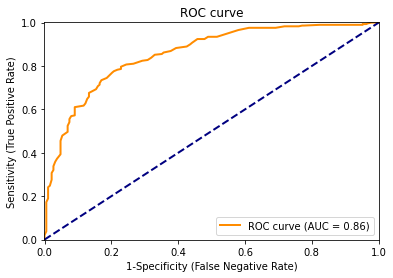

 AUC: 0.8565297138664709


In [151]:
plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Enhancing Model Using GridsearchCV

Optimized hyper-parameters:{'n_estimators': 500}
Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": 

Confusion matrix: 
[[156  75]
 [ 32 215]]
 Accuracy: 0.7761506276150628
 SENSITIVITY (aka RECALL): 0.7413793103448276
 SPECIFICITY (aka FALL-OUT): 0.8297872340425532
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8704453441295547
 NEGATIVE PREDICTIVE VALUE): 0.6753246753246753


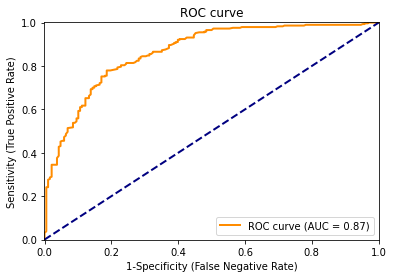

 AUC: 0.8652879677182684


In [153]:
# Hyper-parameter tuning ("optimization") using the function GridSearchCV for maximizing AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [100, 200, 300, 400, 500, 600] 
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ] 

# we will apply a 5-fold cross-validation
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# apply function grid_search to the training data, call the resultand best model grid_search_RF
grid_search_RF = grid_search.fit(X_train, y_train)

# use the best model to predict the testing data
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1] # probabilities  
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # classification

print('Optimized hyper-parameters:' + str(grid_search.best_params_))
    
# Lets look at the model metrics

print('Metrics of the Random Forest model with the optimized hyper-parameter for the "number of trees": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Confusion matrix: \n" + str(cm))

print(" Accuracy: " + str(custom_accuracy_score(y_test, y_pred))) 
print(" SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print(" SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print(" NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))

# Checking features that contribute to Customer Retention

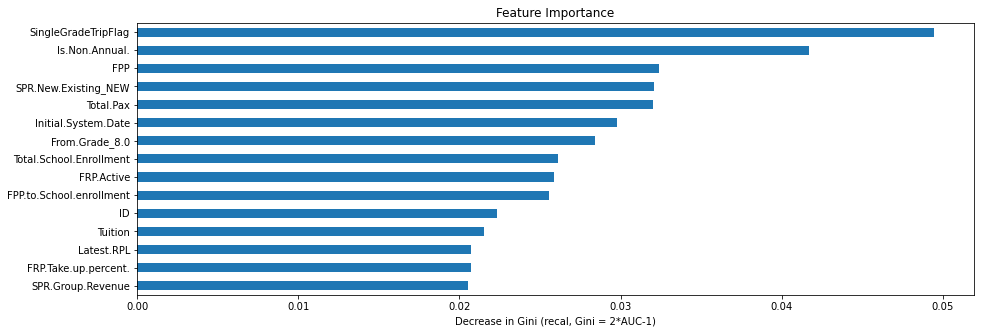

In [154]:
# calculate feature importances
importances = grid_search_RF.best_estimator_.feature_importances_ 

# plot them
plt.figure(figsize=(15,5))
plt.title('Feature Importance')
plt.xlabel('Decrease in Gini (recal, Gini = 2*AUC-1)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')